In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
from lib import data
from lib import sar
from lib import io
from lib import trainer_C
from sklearn.ensemble import RandomForestRegressor
from progressbar import progressbar as pbar

In [2]:
base_path = "/home/alberto/data/data/RST2/Barcelona"
#date_train = '20100520'
#date_test  = '20120720'

date_test = '20100520'
date_train  = '20120720'

window_size = 7

In [3]:
smtr = io.load_bcn_scatter_matrix(base_path, date_train)
smts = io.load_bcn_scatter_matrix(base_path, date_test)

In [4]:
cmtr = sar.avgpool2D_complex(sar.compute_coherence_matrix(smtr), window_size = window_size)
cmts = sar.avgpool2D_complex(sar.compute_coherence_matrix(smts), window_size = window_size)

In [5]:
smtr.shape, cmtr.shape

((4402, 1602, 2, 2), (628, 228, 3, 3))

## define train/test/val split mask

may use spatial split to attempt to avoid spatial leakage between train, test, val

In [6]:
h, w, _, _ = cmtr.shape

splitmask_random = data.cv_splitpixels_random(h, w, train_pct = .70, test_pct = .15, val_pct = .15)
splitmask_bands  = data.cv_splitpixels_spatial(h, w, pixels_train = 70, pixels_test = 15, pixels_val = 15, angle = np.pi/4)

TRAIN, TEST, VAL = 0,1,2

In [7]:
cmtr_VV_ampl = (cmtr[:,:,2,2]).real
cmts_VV_ampl = (cmts[:,:,2,2]).real

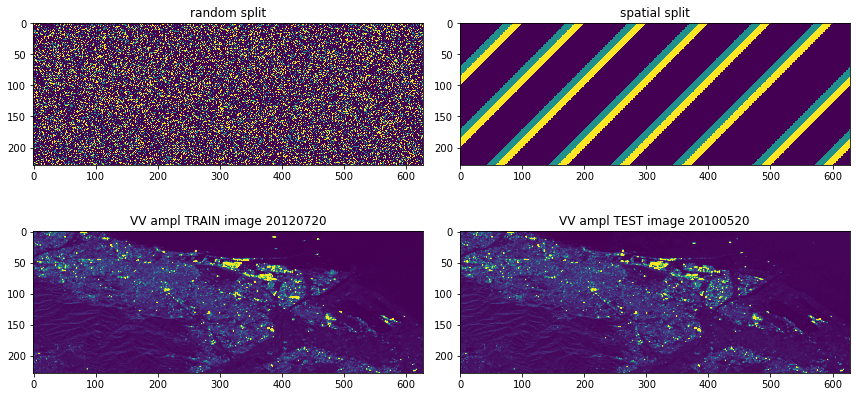

In [8]:
a,b = np.percentile(list(cmtr_VV_ampl.flatten()) + list(cmts_VV_ampl.flatten()), [1,99])

for ax, i in subplots(4, usizex=6, n_cols=2):
    if i==0: plt.imshow(splitmask_random.T, interpolation='none'); plt.title("random split")
    if i==1: plt.imshow(splitmask_bands.T, interpolation='none'); plt.title("spatial split")
    if i==2: plt.imshow(cmtr_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TRAIN image {date_train}") 
    if i==3: plt.imshow(cmts_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TEST image {date_test}") 

# Train random forest - Original parameters

**input**: $\mathbf{C}_{22}$, $\mathbf{C}_{33}$, $Re(\mathbf{C}_{23})$ and $Im(\mathbf{C}_{23})$ from covariance matrix (4 values) 

**output**: $\langle |S_{hh}|^2 \rangle $, aka $\mathbf{C}_{11}$ , real part (imag is zero)

### build train and test data

In [9]:
splitmask = splitmask_bands
t = trainer_C.Trainer_C(cmtr, cmts, cmtr, cmts, splitmask, [(1,1), (1,2), (2,2)], (0,0)).split()
t.xtr.shape, t.xts.shape, t.ytr.shape, t.yts.shape

((102144, 4), (20520, 4), (102144,), (20520,))

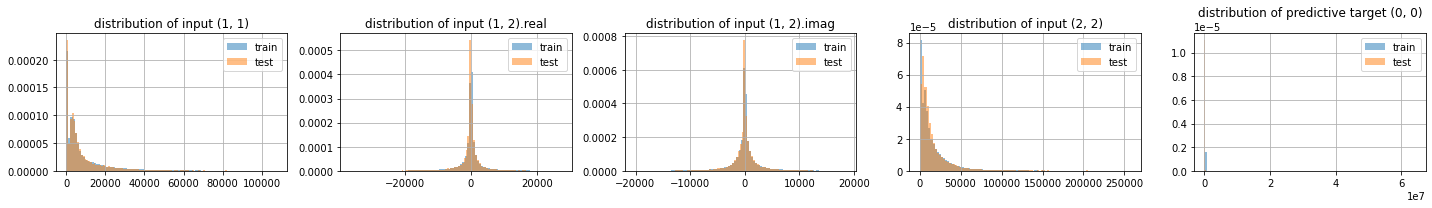

In [10]:
t.plot_distributions()

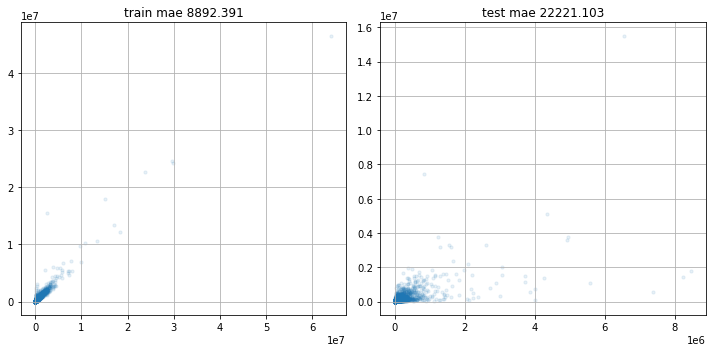

In [11]:
t.set_estimator(RandomForestRegressor(max_depth=50, n_estimators=20, n_jobs=6))
t.fit()
t.plot_predictions()

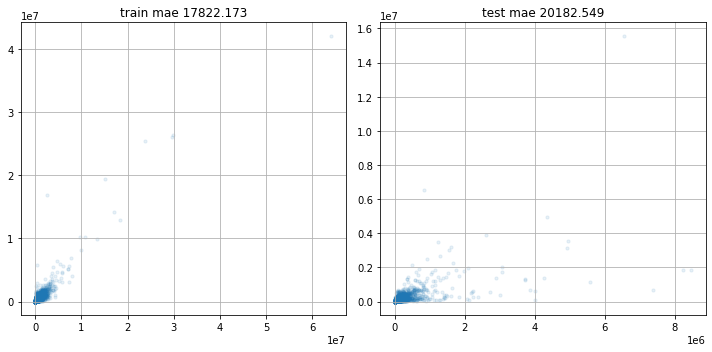

In [12]:
t.set_estimator(RandomForestRegressor(max_depth=10, n_estimators=20, n_jobs=6))
t.fit()
t.plot_predictions()

### increasing RF complexity

In [13]:
depths = list(range(1,100,5))
errs = []
for depth in pbar(depths):
    t.set_estimator(RandomForestRegressor(max_depth=depth, n_estimators=20, n_jobs=6))
    t.fit()
    errs.append([t.errtr, t.errts])
errs = np.r_[errs]
errs_tr = errs[:,0]
errs_ts = errs[:,1]


100% (20 of 20) |########################| Elapsed Time: 0:00:50 Time:  0:00:500204


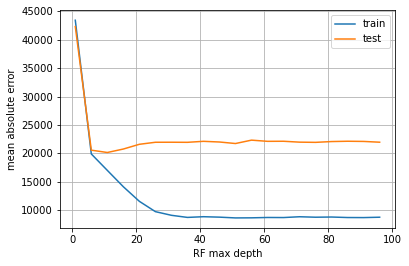

In [14]:
plt.plot(depths, errs_tr, label='train')
plt.plot(depths, errs_ts, label='test')
plt.grid();
plt.xlabel("RF max depth")
plt.ylabel("mean absolute error")
plt.legend()

# Train random forest - Normalized Covariance matrix outputparameters

**input**: $\mathbf{C}_{22}$, $\mathbf{C}_{33}$, $Re(\mathbf{C}_{23})$ and $Im(\mathbf{C}_{23})$ from covariance matrix (4 values) 

**output**: $\langle |S_{hh}|^2 \rangle / T $, aka $\mathbf{C}_{11} / T$  or $\delta_1$, real part (imag is zero)

In [15]:
ncmtr = cmtr / np.einsum("...ii->...", cmtr).real [..., None, None]
ncmts = cmts / np.einsum("...ii->...", cmts).real [..., None, None]

In [16]:
splitmask = splitmask_bands
#splitmask = splitmask_random
t = trainer_C.Trainer_C(cmtr, cmts, ncmtr, ncmts, splitmask, [(1,1), (1,2), (2,2)], (0,0)).split()
t.xtr.shape, t.xts.shape, t.ytr.shape, t.yts.shape

((102144, 4), (20520, 4), (102144,), (20520,))

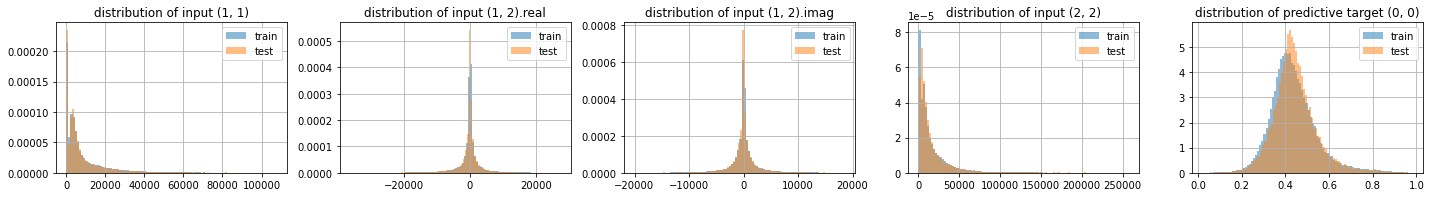

In [17]:
t.plot_distributions()

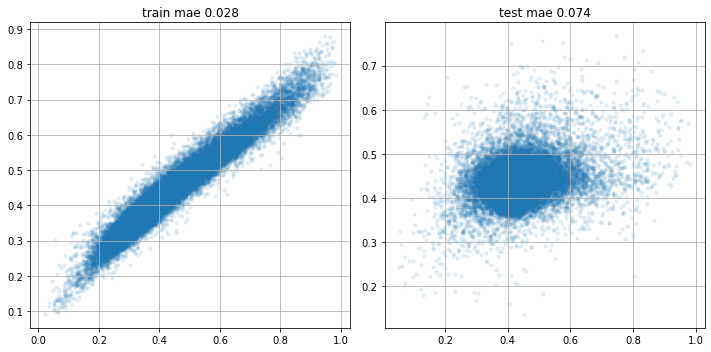

In [18]:
t.set_estimator(RandomForestRegressor(max_depth=50, n_estimators=100, n_jobs=6))
t.fit()
t.plot_predictions()

# Train random forest - Matrix Log parameters

**input**: $\mathbf{L}_{11}$, $\mathbf{L}_{22}$, $Re(\mathbf{L}_{12})$ and $Im(\mathbf{L}_{12})$ from the matrix logarithm of the 2 by 2 subcovariance matrix corresponding to HV and VV polarizations $\mathbf{L} = \log \mathbf{C}_{22 - 33}$ (4 values) 

**output**: $\mathbf{L}_{11} $, real part (imag is zero) from the matrix logarithm of the 3 by 3 full-pol covariance matrix $\mathbf{L} = \log \mathbf{C}$

In [19]:
lcmtr = sar.matlog(cmtr)
lcmts = sar.matlog(cmts)
lcmtr2 = sar.matlog(cmtr[...,1:3, 1:3])
lcmts2 = sar.matlog(cmts[...,1:3, 1:3])
lcmtr.shape, lcmtr2.shape

((628, 228, 3, 3), (628, 228, 2, 2))

In [20]:
lcmtr_VV_ampl = (lcmtr[:,:,2,2]).real
lcmts_VV_ampl = (lcmts[:,:,2,2]).real

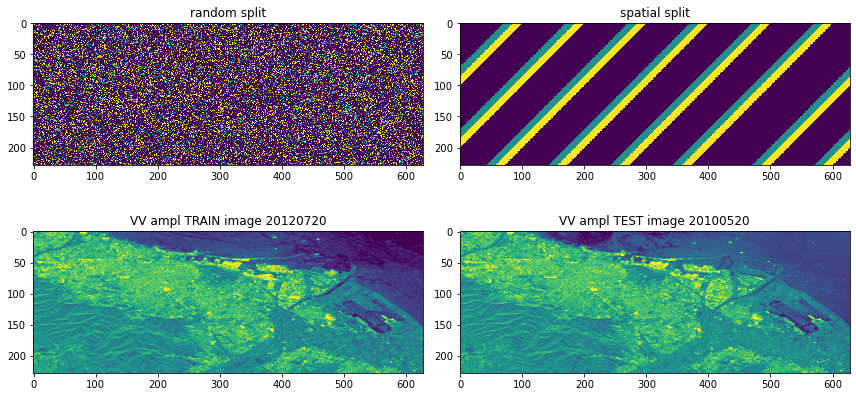

In [21]:
a,b = np.percentile(list(lcmtr_VV_ampl.flatten()) + list(lcmts_VV_ampl.flatten()), [1,99])

for ax, i in subplots(4, usizex=6, n_cols=2):
    if i==0: plt.imshow(splitmask_random.T, interpolation='none'); plt.title("random split")
    if i==1: plt.imshow(splitmask_bands.T, interpolation='none'); plt.title("spatial split")
    if i==2: plt.imshow(lcmtr_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TRAIN image {date_train}") 
    if i==3: plt.imshow(lcmts_VV_ampl.T, vmin=a, vmax=b); plt.title(f"VV ampl TEST image {date_test}") 

In [22]:
splitmask = splitmask_bands
#splitmask = splitmask_random
#t = trainer_C.Trainer_C(lcmtr, lcmts, lcmtr, lcmts, splitmask, [(1,1), (1,2), (2,2)], (0,0)).split()
t = trainer_C.Trainer_C(lcmtr2, lcmts2, lcmtr, lcmts, splitmask, [(0,0), (0,1), (1,1)], (0,0)).split()
t.xtr.shape, t.xts.shape, t.ytr.shape, t.yts.shape

((102144, 4), (20520, 4), (102144,), (20520,))

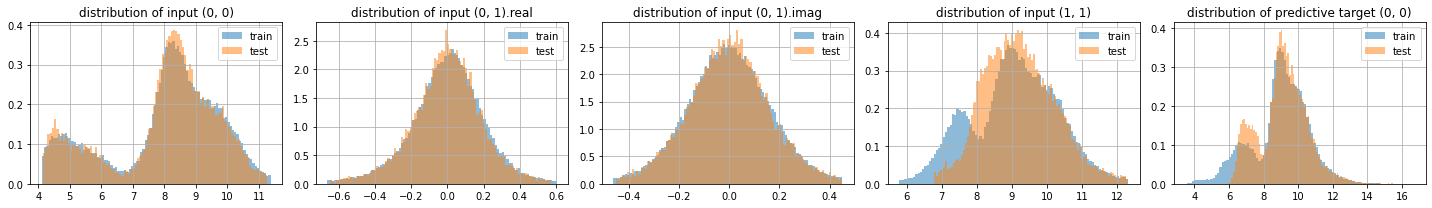

In [23]:
t.plot_distributions()

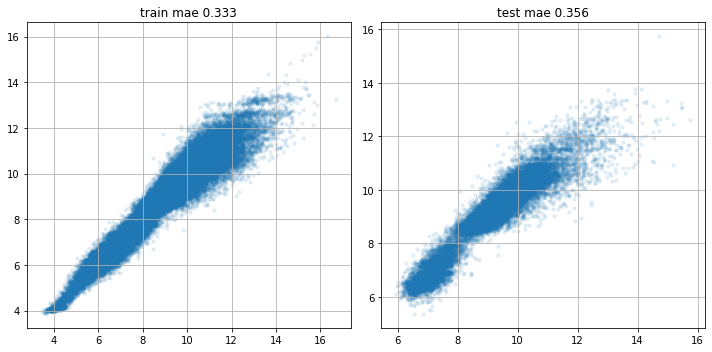

In [24]:
t.set_estimator(RandomForestRegressor(max_depth=10, n_estimators=100, n_jobs=6))
t.fit()
t.plot_predictions()

### increasing RF complexity

In [25]:
depths = list(range(1,50,3))
errs = []
for depth in pbar(depths):
    t.set_estimator(RandomForestRegressor(max_depth=depth, n_estimators=20, n_jobs=16))
    t.fit()
    errs.append([t.errtr, t.errts])
errs = np.r_[errs]
errs_tr = errs[:,0]
errs_ts = errs[:,1]


100% (17 of 17) |########################| Elapsed Time: 0:00:18 Time:  0:00:180102


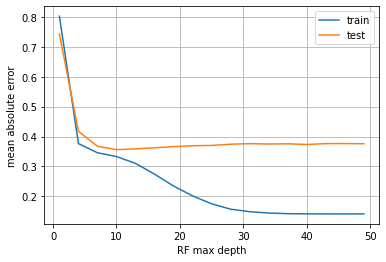

In [26]:
plt.plot(depths, errs_tr, label='train')
plt.plot(depths, errs_ts, label='test')
plt.grid();
plt.xlabel("RF max depth")
plt.ylabel("mean absolute error")
plt.legend()

In [27]:
nests = list(range(10,210,10))
errs = []
for nest in pbar(nests):
    t.set_estimator(RandomForestRegressor(max_depth=10, n_estimators=nest, n_jobs=16))
    t.fit()
    errs.append([t.errtr, t.errts])
errs = np.r_[errs]
errs_tr = errs[:,0]
errs_ts = errs[:,1]


100% (20 of 20) |########################| Elapsed Time: 0:00:52 Time:  0:00:520204


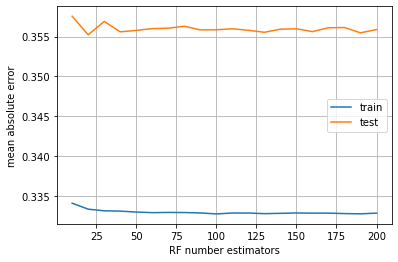

In [28]:
plt.plot(nests, errs_tr, label='train')
plt.plot(nests, errs_ts, label='test')
plt.grid();
plt.xlabel("RF number estimators")
plt.ylabel("mean absolute error")
plt.legend()